In [1]:
# Importar librerias
import pandas as pd
import netCDF4 as nc
import numpy as np
import cv2
import os
import errno
import geopandas as gpd
import seaborn as sns
import shapely
from shapely.geometry import shape, Polygon, Point, MultiPoint, box, LineString
from geopy.distance import geodesic

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from cmcrameri import cm
from cartopy.io.shapereader import Reader as sf
from cartopy.feature import ShapelyFeature as cfeature
import cartopy.io.img_tiles as cimgt

In [420]:
# FUNCIONES UTILES
def clasificar_municipio(lat_mun, lon_mun, lat_ciclon, lon_ciclon, m_perpendicular, direccion_movimiento):
    # Calcular si un municipio está 'delante' o 'detrás' de la línea perpendicular
    y_esperado = m_perpendicular * (lon_mun - lon_ciclon) + lat_ciclon
    
    if direccion_movimiento <= 180:
        return 'Acercando' if lat_mun > y_esperado else 'Alejando'
    else:
        return 'Acercando' if lat_mun < y_esperado else 'Alejando'

# Función para calcular la distancia
def calcular_distancia(row):
    return geodesic(coord_ciclon, (row.centroide.y, row.centroide.x)).km

# Función para calcular el tiempo de arribo
def calcular_tiempo(row):
    distancia_km = geodesic(coord_ciclon, (row.centroide.y, row.centroide.x)).km
    if distancia_km == 0 or velocidad_ciclon_kmh == 0:
        return np.inf
    return distancia_km / velocidad_ciclon_kmh

def configurar_mapa(ax, lon_extent=[-98, -86], lat_extent=[ 14, 22]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=16)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 1), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 1), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 1), ylocs=range(lat_extent[0], lat_extent[1] + 1, 1))

In [3]:
# TABLA DE ACERCAMIENTO
TA = pd.DataFrame()
TA[0] = [1,1,1,1,1,1]
TA[1] = [2,2,2,2,2,2]
TA[2] = [2,2,2,2,3,3]
TA[3] = [2,2,3,3,3,3]
TA[4] = [2,3,3,3,4,4]
TA[5] = [3,3,4,4,4,4]
TA[6] = [3,4,4,4,4,4]
TA[7] = [4,4,4,4,5,5]
TA[8] = [5,5,5,5,5,5]

def class_h(val):
    if val > 72:
        i = 0
    elif (val <72)&(val>=60):
        i = 1
    elif (val <60)&(val>=48):
        i = 2
    elif (val <48)&(val>=36):
        i = 3
    elif (val <36)&(val>=24):
        i = 4
    elif (val <24)&(val>=18):
        i = 5
    elif (val <18)&(val>=12):
        i = 6
    elif (val <12)&(val>=6):
        i = 7
    elif (val <6):
        i = 8
    return i 

In [4]:
# TABLA DE ALEJAMIENTO
TL = pd.DataFrame()
TL[0] = [5,5,5,5,5,5]
TL[1] = [4,4,5,5,5,5]
TL[2] = [4,4,4,4,5,5]
TL[3] = [3,4,4,4,4,5]
TL[4] = [3,3,3,4,4,4]
TL[5] = [3,3,3,3,4,4]
TL[6] = [2,3,3,3,3,4]
TL[7] = [2,2,2,3,3,3]
TL[8] = [2,2,2,2,2,2]
TL[9] = [1,1,1,1,1,1]

def class_d(val):
    if val < 100:
        i = 0
    elif (val <150)&(val>=100):
        i = 1
    elif (val <200)&(val>=150):
        i = 2
    elif (val <250)&(val>=200):
        i = 3
    elif (val <300)&(val>=250):
        i = 4
    elif (val <350)&(val>=300):
        i = 5
    elif (val <400)&(val>=350):
        i = 6
    elif (val <500)&(val>=400):
        i = 7
    elif (val <750)&(val>=500):
        i = 8
    elif (val >=750):
        i = 9
    return i 

In [5]:
def cambiar_sufijos(df,col):
    lon1 = df[col].to_numpy()
    for i in range(len(lon1)):
        if lon1[i][-1] == 'W':
            lon1[i]  = lon1[i].replace("W","")
            lon1[i] = float(lon1[i]) * -1
        else:
            lon1[i]  = lon1[i].replace("E","").replace("N","")
            lon1[i] = float(lon1[i])
    return lon1

def calculate_danger_level(fraction):
    if fraction == 0:
        return 0
    elif 0 < fraction <= 0.2:
        return 1
    elif 0.2 < fraction <= 0.4:
        return 2
    elif 0.4 < fraction <= 0.6:
        return 3
    elif 0.6 < fraction <= 0.8:
        return 4
    elif 0.8 < fraction <= 1:
        return 5
    return 0  # En caso de cualquier otra eventualidad, se considera peligro 0


In [6]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

pcp_rain = make_colormap([c('white'),1/20, c('cyan'), 2/20, c('dodgerblue'),
    3/20,c('palegreen'),4/20,c('lawngreen'),5/20,c('yellowgreen'),6/20,c('forestgreen'),
    7/20,c('yellow'),8/20,c('gold'),9/20,c('orange'),10/20, c('darkorange'), 11/20, c('red'),
    12/20,c('firebrick'),13/20,c('maroon'),14/20,c('deeppink'),15/20,c('crimson'),
    16/20,c('mediumvioletred'),17/20,c('violet'),18/20,c('mediumpurple'), 19/20,c('slateblue')])

In [7]:
fname = '../cap_book_ct/destdv1gw/destdv1gw.shp'
estados = gpd.read_file(fname)

# Cargar los datos de trayectoria e información del CT
### Descripcion de la información 

**'NAME'**: Name provided by the agency.

**'ISO_TIME'**: ISO Time provided in Universal Time Coordinates (UTC). Format is YYYY-MM-DD HH mm ss

**'USA_LAT'**: deg north

**'USA_LON'**: deg_east

**'USA_WIND'**: Maximum sustained wind speed in knots: 0 - 300 kts.

**'USA_PRES'**: Minimum sea level pressure, 850 - 1050 mb.

**'USA_SSHS'**: Saffir-Simpson Hurricane Scale information based on the wind speed provided by the US agency wind speed (US agencies provide 1-minute wind speeds): 

        * -5 = Unknown [XX]
        * -4 = Post-tropical [EX, ET, PT]
        * -3 = Miscellaneous disturbances [WV, LO, DB, DS, IN, MD]
        * -2 = Subtropical [SS, SD]
        
        Tropical systems classified based on wind speeds:
        * -1 = Tropical depression (W<34)
        * 0 = Tropical storm [34<W<64]
        * 1 = Category 1 [64<=W<83] 
        * 2 = Category 2 [83<=W<96] 
        * 3 = Category 3 [96<=W<113]
        * 4 = Category 4 [113<=W<137] 
        * 5 = Category 5 [W >= 137]

**'USA_R34_NE'**: 34 kt wind radii maximum extent in northeastern quadrant in nautical milles

**'USA_R34_SE'**: 34 kt wind radii maximum extent in southeastern quadrant in nautical milles

**'USA_R34_SW'**: 34 kt wind radii maximum extent in southwestern quadrant in nautical milles

**'USA_R34_NW'**: 34 kt wind radii maximum extent in northwestern quadrant in nautical milles

**'STORM_SPD'**: Translation speed of the system as calculated from the positions in LAT and LON in knots

**'STORM_DR'**: Translation direction of the system as calculated from the positions in LAT and LON. Direction is moving toward the vector pointing in degrees east of north [range = 0-360 deg]

In [8]:
ct_ibtracs = gpd.read_file('cristobal_ibtracks.shp')
columnas = [5,6,19,20,23,24,25,26,27,28,29,161,162]
ct_ibtracs_info = ct_ibtracs.iloc[:,columnas]

In [9]:
# limpieza para aquellas posiciones que requieren alertamientos (-1 a 5)

df = ct_ibtracs_info[ct_ibtracs_info.USA_SSHS.ge(-1)].copy()

Para empezar es necesario calcular la peligrosidad asociada al SIAT-CT para cada CT. Para ello necesitamos los valores de 

**Escala de Intensidad** : ['ESC_INT'] Categoría del Huracán en la escala Saffir-Simpson o I = 0 si se trata de una Depresión o una Tormenta Tropical.

**Escala de Circulación** : ['ESC_CIR'] la Escala de Circulación y se obtiene de: C = 0.0377 R; donde R es el radio promedio (en millas náuticas) de los cuatro cuadrantes de la isotaca de 34 nudos (63 km/h)

In [10]:
## Escala de intensidad 
df['ESC_INT'] = df['USA_SSHS'].apply(lambda x: x if x >= 1 else 0)

In [11]:
## Escala de circulación
df['R'] = df[['USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW']].mean(axis=1)
df['R'] = df['R'].ffill()
df['ESC_CIR'] = 0.0377 * df['R']
# Ajustar los valores de ESC_CIR para que ningún valor exceda de 5
df['ESC_CIR'] = np.where(df['ESC_CIR'] > 5, 5, df['ESC_CIR'])

In [111]:
1/(0.0337*2)

14.836795252225519

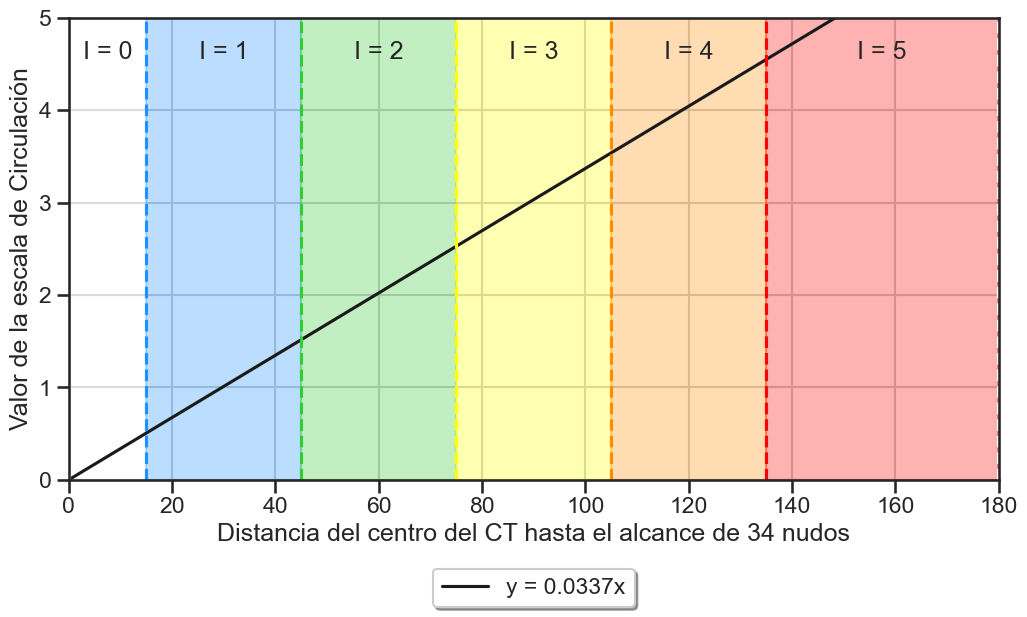

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", context="talk", rc=custom_params)

# Valores de x desde 0 hasta 150
x = np.linspace(0, 160, 400)
y = 0.0337 * x

plt.figure(figsize=(12, 6))  # tamaño de la figura
plt.plot(x, y, label='y = 0.0337x', color='k')

# Marcas para los puntos donde y es 1, 2, 3, 4, y 5
ys = [0, 1, 2, 3, 4, 5]
xs = [0, 15, 45, 75, 105, 135, 179.8]

# Definir colores y etiquetas
colors = ['white','dodgerblue', 'limegreen', 'yellow', 'darkorange', 'red','white']
labels = ['I = 0', 'I = 1', 'I = 2', 'I = 3', 'I = 4', 'I = 5','']

# Dibujar líneas verticales y sombrear áreas
for i in range(len(xs)):
    plt.axvline(xs[i], color=colors[i], linestyle='--')
    if i < len(xs) - 1:
        plt.fill_betweenx(y, xs[i], xs[i+1], color=colors[i], alpha=0.3)

# Añadir etiquetas dentro de la gráfica
for i in range(len(xs)-1):
    plt.text((xs[i] + xs[i+1]) / 2, 4.5, 'I = '+ str(i), ha='center', va='bottom')

plt.xlabel('Distancia del centro del CT hasta el alcance de 34 nudos')
plt.ylabel('Valor de la escala de Circulación')
plt.grid(True)
plt.xlim(0, 180)  # ajustar los límites de x
plt.ylim(0, 5)   # ajustar los límites de y
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6, fancybox=True, shadow=True)

plt.savefig("fig_2.jpeg", dpi= 300, bbox_inches='tight')


In [88]:
for i in range(len(xs)):
    print(i)

0
1
2
3
4


#### Calculo de la peligrosidad del CT con la información antes calculada:
El SIAT CT considera la extensión del ciclón tropical en superficie. Para ello se emplea una Escala
Promedio de las escalas Saffir-Simpson y de Circulación.
La Escala Promedio (e) se obtiene con la siguiente ecuación:
$$e = 0.5 (I+C)$$


In [13]:
# Calcular la Escala Promedio (e) usando la fórmula proporcionada
df['ESC_PEL'] = 0.5 * (df['ESC_INT'] + df['ESC_CIR'])
df['ESC_PEL'] = df['ESC_PEL'].round(2)
df['ESC_PEL'] = df['ESC_PEL'].fillna(0)

#### Cálculo del alertamiento por municipio afectado
Para esto es importante considerar la posición del ciclon tropical y apartir de a dirección de movimiento en grados dados por la columna 'STORM_DR' en un rango de 0 a 360, hay que determinar aquellos municipios de los que se aleja el ciclón y de cuales se acerca. Luego una vez separados los municipios en estos dos grupos hay que determinar dos cosas. Para los que se aleja, la distancia del CT al centro en movimiento. Para los que se acerca en cuanto tiempo el ciclón estará cercano. Y esto en función de la velocidad de traslación o desplazamiento del ciclón tropical el cual esta dada por la columna 'STORM_SPD' donde se expresa en nudos dicha velocidad. Toma en cuenta que la distancia de alejamiento es en KM y el tiempo de acercamiento en Horas.

In [14]:
fname = 'C:/Users/adolf/Downloads/municipios/mun22gw.shp'

shapefile = gpd.read_file(fname,  encoding='utf-8')

In [15]:
gdf_municipios = shapefile.loc[(shapefile['CVE_ENT'] == '04')|(shapefile['CVE_ENT'] == '07')|(shapefile['CVE_ENT'] == '20')|
              (shapefile['CVE_ENT'] == '23')|(shapefile['CVE_ENT'] == '27')|(shapefile['CVE_ENT'] == '30')|
              (shapefile['CVE_ENT'] == '31')].reset_index(drop =True)

Primero, calculamos el centroide de cada polígono (municipio). Asumiremos que gdf_municipios es tu GeoDataFrame que contiene la geometría de los municipios.

In [16]:
gdf_municipios['centroide'] = gdf_municipios.geometry.centroid
gdf_municipios['lat_centroide'] = gdf_municipios.centroide.y
gdf_municipios['lon_centroide'] = gdf_municipios.centroide.x

C:\Users\adolf\AppData\Local\Temp\ipykernel_25716\2251888287.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_municipios['centroide'] = gdf_municipios.geometry.centroid


In [17]:
df_ciclon =  df.copy()

# A partir de aqui hayq ue determinar el día para los alertaminetos en la variable indice_dia

In [142]:
alertas = gdf_municipios.iloc[:,:10].sort_values('CVEGEO').copy()

In [145]:
alertas

CVEGEO CVE_ENT CVE_MUN       NOMGEO   NOM_ENT  COV_  COV_ID  \
0     04001      04     001      Calkiní  Campeche    27      34   
1     04002      04     002     Campeche  Campeche    23      26   
2     04003      04     003       Carmen  Campeche    24      24   
3     04004      04     004    Champotón  Campeche    25      27   
4     04005      04     005  Hecelchakán  Campeche    28      33   
...     ...     ...     ...          ...       ...   ...     ...   
1048  31102      31     102   Valladolid   Yucatán  2336    2342   
1049  31103      31     103      Xocchel   Yucatán  2394    2323   
1050  31104      31     104      Yaxcabá   Yucatán  2395    2331   
1051  31105      31     105     Yaxkukul   Yucatán  2415    2410   
1052  31106      31     106       Yobaín   Yucatán  2416    2411   

               AREA      PERIMETER  \
0     171669.022462  383750.911892   
1     321707.798265  425616.817694   
2     854260.277732  817390.971171   
3     653939.952838  577307.788846   
4     126551.450903  255287.575553   
...             ...            ...   
1048  106924.357512  299695.653109   
1049   10981.103343   85937.035897   
1050  146234.564061  274178.071168   
1051    4905.555864   48159.076681   
1052   13052.205978   75415.081965   

                                               geometry  PEL_SIAT_x  \
0     MULTIPOLYGON (((-90.49715 20.34232, -90.49716 ...           4   
1     MULTIPOLYGON (((-90.36505 19.96243, -90.36203 ...           5   
2     POLYGON ((-90.85199 18.83438, -90.84994 18.834...           4   
3     POLYGON ((-89.91278 19.29585, -89.92206 19.216...           5   
4     POLYGON ((-90.12246 20.26742, -90.11638 20.266...           4   
...                                                 ...         ...   
1048  POLYGON ((-87.95724 20.84763, -87.95773 20.846...           3   
1049  POLYGON ((-89.07587 20.82334, -89.08143 20.814...           3   
1050  POLYGON ((-88.69307 20.75231, -88.68907 20.749...           3   
1051  POLYGON ((-89.43150 21.08972, -89.43052 21.089...           3   
1052  POLYGON ((-89.08028 21.21766, -89.08043 21.216...           3   

      PEL_SIAT_y  PEL_SIAT  
0              4         4  
1              4         4  
2              4         4  
3              5         4  
4              4         4  
...          ...       ...  
1048           2         2  
1049           3         3  
1050           3         3  
1051           3         3  
1052           3         3  

[1053 rows x 13 columns]

In [148]:
df_ciclon.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype='int64')

In [157]:
def ajustar_angulo(angulo):
    angulo_ajustado = 90 - angulo
    if angulo_ajustado < 0:
        angulo_ajustado += 360
    return angulo_ajustado

In [172]:
alertas = gdf_municipios.iloc[:,:10].sort_values('CVEGEO').copy()
for indice_dia in df_ciclon.index:
    # Dirección del movimiento del ciclón en grados
    ct = df_ciclon.iloc[indice_dia]
    direccion_movimiento = ajustar_angulo(df_ciclon['STORM_DR'].iloc[indice_dia])
    lat_ciclon, lon_ciclon = df_ciclon['USA_LAT'].iloc[indice_dia], df_ciclon['USA_LON'].iloc[indice_dia]
    #20.2069, -91.9754#
    # Convertir dirección a radianes
    theta_radianes = np.radians(direccion_movimiento)
    
    # Calcular pendiente de la dirección de movimiento y de la perpendicular
    m_movimiento = np.tan(theta_radianes)
    m_perpendicular = -1/m_movimiento

    # Aplicar la función clasificar_municipio a cada fila del GeoDataFrame
    nombre_columna = 'clasificacion_'+df_ciclon.iloc[indice_dia].ISO_TIME[:10]
    gdf_municipios[nombre_columna] = gdf_municipios.apply(
        lambda x: clasificar_municipio(
            x['lat_centroide'], x['lon_centroide'], 
            lat_ciclon, lon_ciclon, 
            m_perpendicular, direccion_movimiento
        ), axis=1
    )

    gdf_acercando = gdf_municipios[gdf_municipios[nombre_columna] == 'Acercando'].copy()
    gdf_alejando = gdf_municipios[gdf_municipios[nombre_columna] == 'Alejando'].copy()

    # Datos del ciclón (ejemplo)
    lat_ciclon = lat_ciclon  # Latitud del centro del ciclón
    lon_ciclon = lon_ciclon  # Longitud del centro del ciclón
    direccion_movimiento = direccion_movimiento  # Dirección de movimiento en grados
    
    # Calcular el desplazamiento de la flecha para la dirección del ciclón
    longitud_flecha = 1  # Longitud de la flecha en grados, ajusta según la escala de tu mapa
    dx = longitud_flecha * np.cos(np.radians(direccion_movimiento))
    dy = longitud_flecha * np.sin(np.radians(direccion_movimiento))

    
    
    # Suponiendo que tienes las coordenadas del centro del ciclón
    coord_ciclon = (lat_ciclon, lon_ciclon)
    
    # Aplicar la función a cada fila para los municipios que se alejan
    if gdf_alejando.shape[0] > 0 :
        gdf_alejando.loc[:,'distancia_km'] = gdf_alejando.apply(calcular_distancia, axis=1)
        peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
        gdf_alejando.loc[:,'PEL_SIAT'] = gdf_alejando['distancia_km'].apply(lambda x: TL.loc[peligro_e,class_d(x)])
    else:
        pass

    df_ciclon['STORM_SPD_KMH'] = df_ciclon['STORM_SPD'] * 1.852
    velocidad_ciclon_kmh = df_ciclon['STORM_SPD_KMH'].iloc[indice_dia]

    if gdf_acercando.shape[0] > 0 :
        gdf_acercando.loc[:,'tiempo_arribo_hrs'] = gdf_acercando.apply(calcular_tiempo, axis=1)
        peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
        gdf_acercando.loc[:,'PEL_SIAT'] = gdf_acercando['tiempo_arribo_hrs'].apply(lambda x: TA.loc[peligro_e,class_h(x)])
    else:
        pass    

    siat_ct = pd.concat([gdf_acercando,gdf_alejando])

    nombre_columa = 'alerta-'+ct.ISO_TIME[:10]+'-'+ct.ISO_TIME[11:13]

    alertas = alertas.merge(siat_ct[['CVEGEO','PEL_SIAT']].set_index('CVEGEO'), on = 'CVEGEO')
    alertas = alertas.rename(columns = {'PEL_SIAT':nombre_columa})
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


In [173]:
alertas.columns

Index(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'NOMGEO', 'NOM_ENT', 'COV_', 'COV_ID',
       'AREA', 'PERIMETER', 'geometry', 'alerta-2020-06-01-18',
       'alerta-2020-06-01-21', 'alerta-2020-06-02-00', 'alerta-2020-06-02-03',
       'alerta-2020-06-02-06', 'alerta-2020-06-02-09', 'alerta-2020-06-02-12',
       'alerta-2020-06-02-15', 'alerta-2020-06-02-18', 'alerta-2020-06-02-21',
       'alerta-2020-06-03-00', 'alerta-2020-06-03-03', 'alerta-2020-06-03-06',
       'alerta-2020-06-03-09', 'alerta-2020-06-03-12', 'alerta-2020-06-03-13',
       'alerta-2020-06-03-15', 'alerta-2020-06-03-18', 'alerta-2020-06-03-21',
       'alerta-2020-06-04-00', 'alerta-2020-06-04-03', 'alerta-2020-06-04-06',
       'alerta-2020-06-04-09', 'alerta-2020-06-04-12', 'alerta-2020-06-04-15',
       'alerta-2020-06-04-18', 'alerta-2020-06-04-21', 'alerta-2020-06-05-00',
       'alerta-2020-06-05-03', 'alerta-2020-06-05-06', 'alerta-2020-06-05-09',
       'alerta-2020-06-05-12', 'alerta-2020-06-05-15', 'alerta-2020-

In [163]:
indice_dia =  2
# Dirección del movimiento del ciclón en grados
ct = df_ciclon.iloc[indice_dia]
direccion_movimiento = df_ciclon['STORM_DR'].iloc[indice_dia] - 90
lat_ciclon, lon_ciclon = df_ciclon['USA_LAT'].iloc[indice_dia], df_ciclon['USA_LON'].iloc[indice_dia]
#20.2069, -91.9754#
# Convertir dirección a radianes
theta_radianes = np.radians(direccion_movimiento)

# Calcular pendiente de la dirección de movimiento y de la perpendicular
m_movimiento = np.tan(theta_radianes)
m_perpendicular = -1/m_movimiento

In [174]:
danger_colors = {
    0: 'grey',
    1: 'dodgerblue',
    2: 'limegreen',
    3: 'yellow',
    4: 'darkorange',
    5: 'red'
}

In [202]:
ct

NAME             ISO_TIME  USA_LAT  USA_LON  USA_WIND  USA_PRES  \
10  CRISTOBAL  2020-06-03 00:00:00     19.0    -92.5      45.0     996.0   

    USA_SSHS  USA_R34_NE  USA_R34_SE  USA_R34_SW  USA_R34_NW  STORM_SPD  \
10         0        60.0        50.0        50.0        60.0        2.0   

    STORM_DR  ESC_INT     R  ESC_CIR  ESC_PEL  STORM_SPD_KMH  
10     131.0        0  55.0   2.0735     1.04          3.704

Text(0.5, 1.0, 'Alertamientos del CT CRISTOBAL para el 2020-06-03 00:00:00')

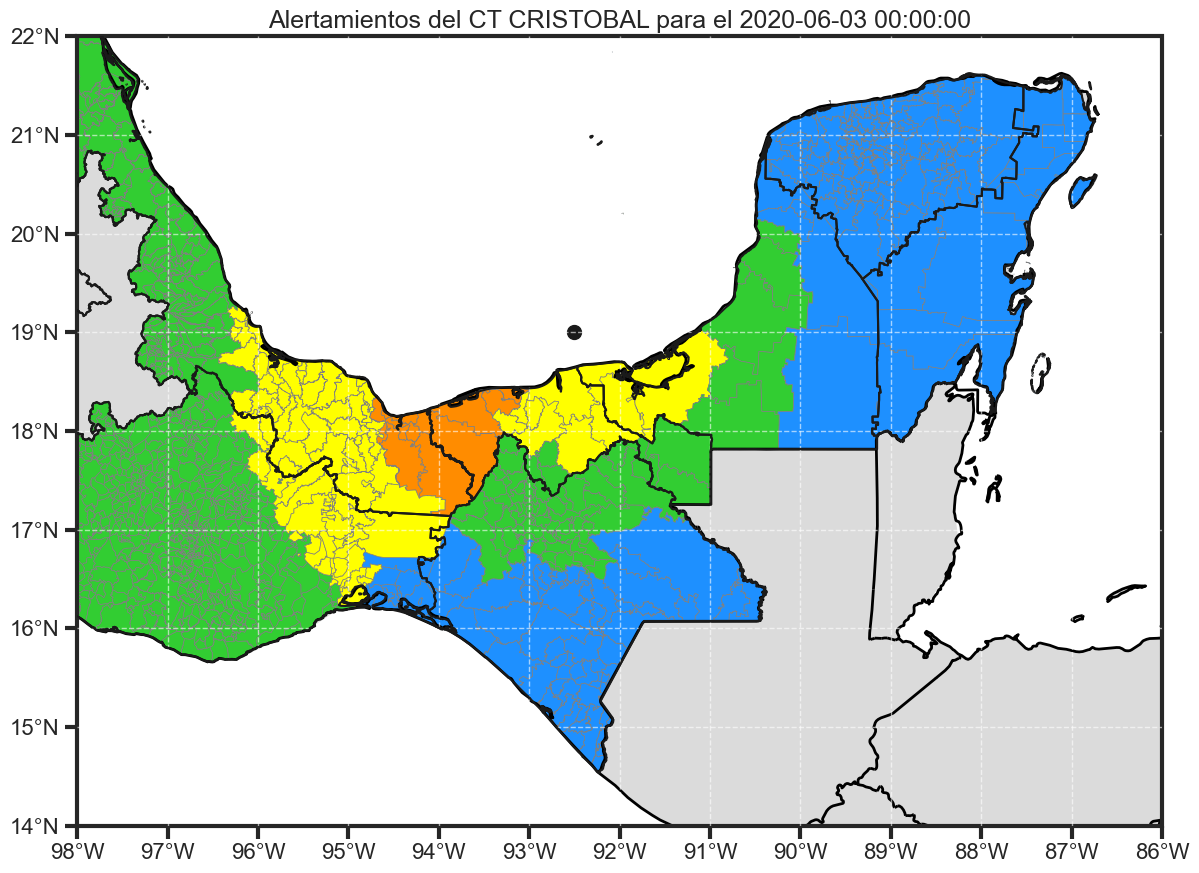

In [203]:
col  =  'alerta-2020-06-03-00'
n_col = col[7:-3] + ' ' +  col[18:]+':00:00'

ct = df_ciclon[df_ciclon.ISO_TIME.eq(n_col)]

escala_a_usar = []
for colors in alertas[col].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

cmap = ListedColormap(escala_a_usar)

f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)

alertas.plot(column=col, ax=ax, cmap=cmap, edgecolor='grey', linewidth=0.5)
estados.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1.5, zorder=3)

ax.plot(ct.USA_LON.values[0], ct.USA_LAT.values[0], marker='o', color='k', markersize= 10, transform=ccrs.Geodetic(), label='Centro del Ciclón')

plt.title('Alertamientos del CT '+ct.NAME.values[0]+' para el '+ct.ISO_TIME.values[0])

In [250]:
siat_cris = pd.read_excel('../cap_book_ct/mapa.xlsx')

In [274]:
siat_cris = siat_cris[['CVEGEO',    'CVE_ENT',    'CVE_MUN',    'NOM_ENT', 'AREA',  'PERIMETER',       'COV_',     'COV_ID',    'NOM_MUN',
         'geometry', 'a',          'b',          'c',          'd']].fillna(0)
siat_cris['CVEGEO'] = siat_cris['CVEGEO'].astype(int)

In [275]:
col_int = ['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'NOMGEO', 'NOM_ENT', 'COV_', 'COV_ID',
       'AREA', 'PERIMETER', 'geometry','alerta-2020-06-01-21', 'alerta-2020-06-03-21', 'alerta-2020-06-04-12', 'alerta-2020-06-04-15']
mapas_cris = alertas[col_int]
mapas_cris['CVEGEO'] = mapas_cris['CVEGEO'].astype(int)

C:\Users\adolf\miniconda3\envs\ml_project\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [276]:
dif = mapas_cris.copy()

In [277]:
def resta_y_asignacion(columna1, columna2):
    diferencia = columna1 - columna2
    if diferencia < 0:
        return 7
    elif diferencia == 0:
        return 8
    else:
        return 9

In [278]:
cols_merge = ['CVEGEO',  'a',          'b',          'c',          'd']
dif = dif.merge(siat_cris[cols_merge].set_index('CVEGEO'), on= 'CVEGEO')


In [279]:
dif['i'] = dif.apply(lambda row: resta_y_asignacion(row['a'], row['alerta-2020-06-01-21']), axis=1)
dif['j'] = dif.apply(lambda row: resta_y_asignacion(row['b'], row['alerta-2020-06-03-21']), axis=1)
dif['k'] = dif.apply(lambda row: resta_y_asignacion(row['c'], row['alerta-2020-06-04-12']), axis=1)
dif['l'] = dif.apply(lambda row: resta_y_asignacion(row['d'], row['alerta-2020-06-04-15']), axis=1)

In [280]:
dif = dif.rename(columns = {'alerta-2020-06-01-21':'e',
                 'alerta-2020-06-03-21':'f',
                 'alerta-2020-06-04-12':'g',
                 'alerta-2020-06-04-15':'h'})

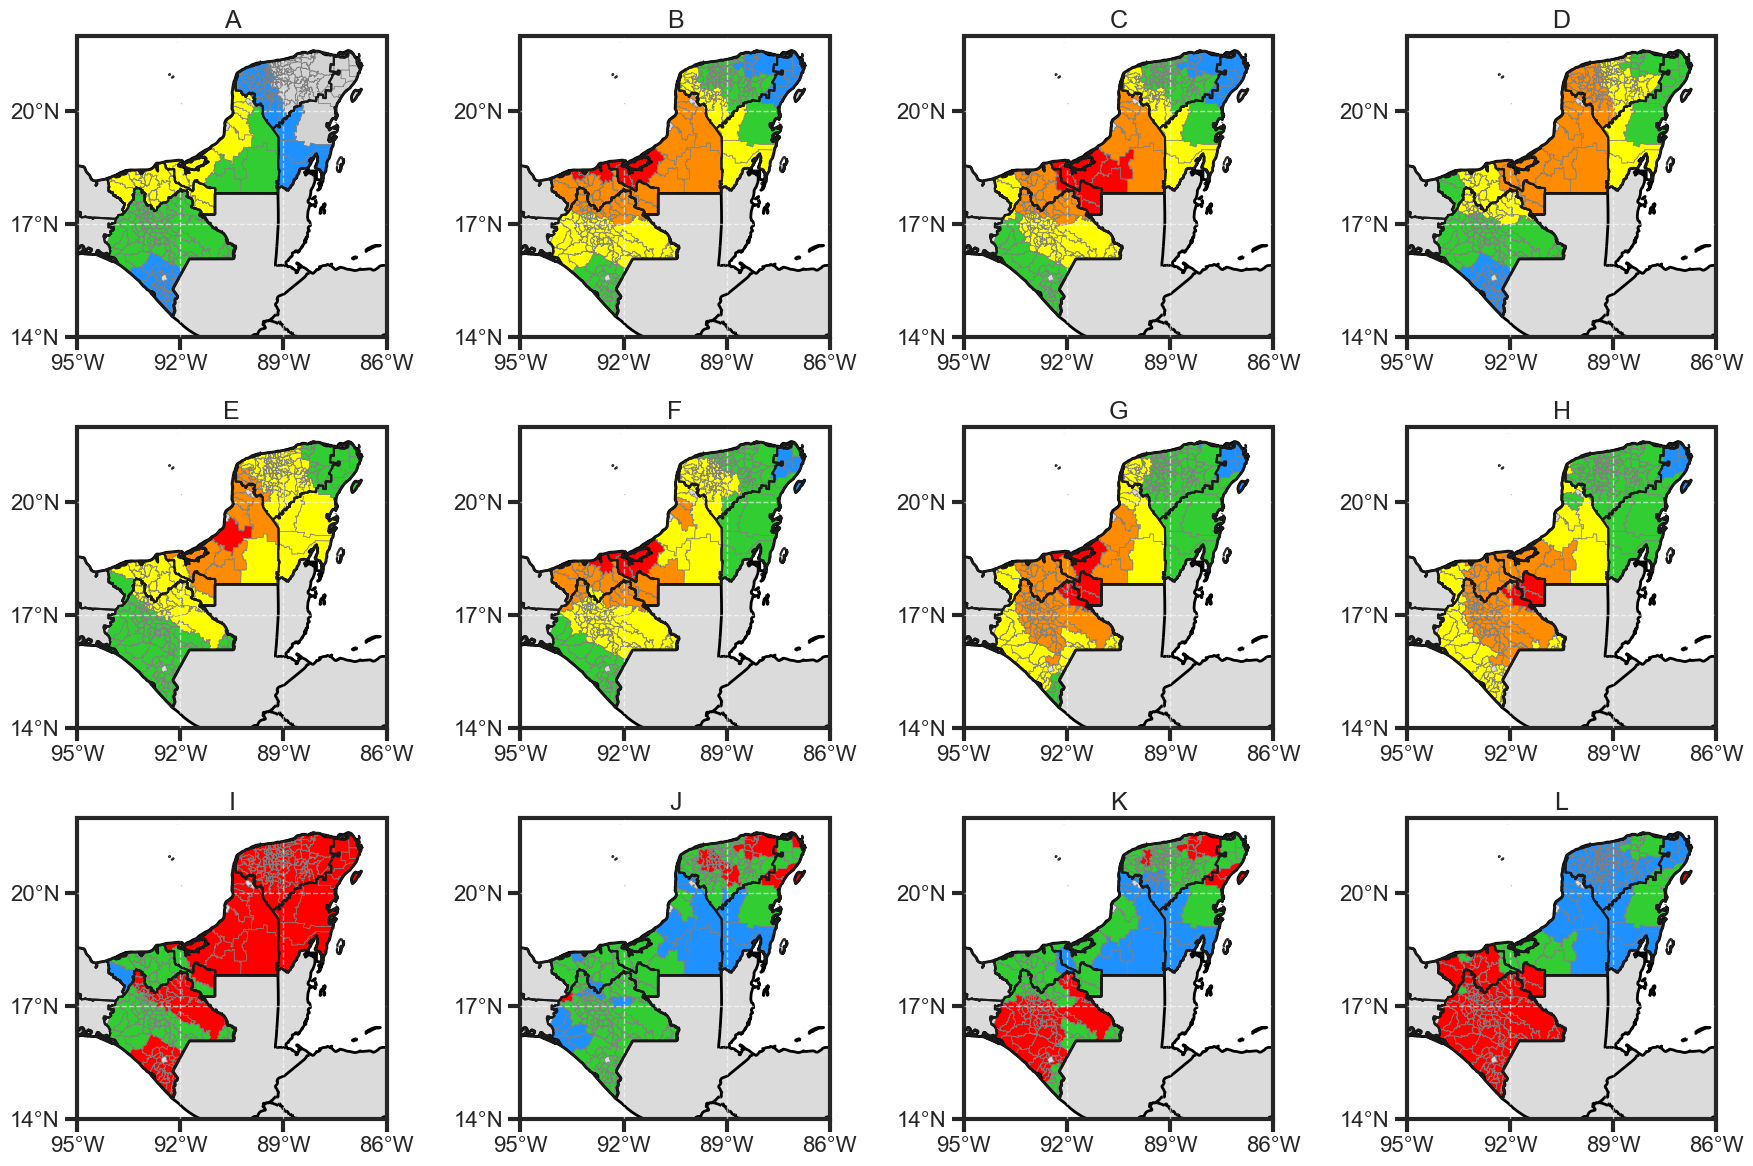

In [399]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import numpy as np
import string

def configurar_mapa(ax, lon_extent=[-95, -86], lat_extent=[14, 22]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=16)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 3), ylocs=range(lat_extent[0], lat_extent[1] + 1, 3))

danger_colors = {
    0: 'lightgrey',
    1: 'dodgerblue',
    2: 'limegreen',
    3: 'yellow',
    4: 'darkorange',
    5: 'red',
    7: 'red',
    8: 'limegreen',
    9: 'dodgerblue',
}

fig, axs = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Lista de letras del alfabeto
# Lista de letras del alfabeto de la 'a' a la 'l'
letras = list(string.ascii_lowercase)[:12]

# Iterar sobre las filas y columnas del subplot
for i, fila in enumerate(axs):
    for j, ax in enumerate(fila):
        # Calcular el índice de la letra correspondiente y seleccionar la letra del alfabeto
        index = i * 4 + j
        if index < len(letras):
            columna = letras[index]
            escala_a_usar = []
            for colors in dif[columna].sort_values().unique():
                color_escala =  danger_colors[colors]
                escala_a_usar.append(color_escala)
            
            cmap = ListedColormap(escala_a_usar)
            configurar_mapa(ax)
            
            dif.plot(column=columna, ax=ax, cmap=cmap, edgecolor='grey', linewidth=0.5)
            estados.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1.5, zorder=3)
            
            ax.set_title(f'{columna.upper()}')

plt.tight_layout()
plt.savefig("fig_8.jpeg", dpi= 300, bbox_inches='tight')


## PELIGRO POR VIENTOS 

In [32]:
datos = 'AL032020.dat'
names = ['date', 'time', 'lat', 'lon', 'MWS', 'CPSL', 'ERMWS', 'R34', 'R50', 'R64', 'R100', 'TCOR']
df1 = pd.read_csv(datos, sep=",", skip_blank_lines=True, header = None, names = names)
fecha = pd.to_datetime(df1['date'], format='%Y%m%d').apply(lambda x: pd.Series([x.year,x.month,x.day], index = ['yy', 'mm', 'dd']))
dd = fecha['dd']
mm = fecha['mm']
yy = fecha['yy']
hh = (df1['time']/100).astype(int)
lat = cambiar_sufijos(df1,'lat')
lon = cambiar_sufijos(df1,'lon')
R34 = df1['R34']
ROUT = df1['TCOR']
ERMWS = df1['ERMWS']
d = {'dd':dd,'mm':mm,'yy':yy,'hh':hh,'lat':lat,'lon':lon,'R34':R34,'R':ROUT, 'RMAX':ERMWS}
data = pd.DataFrame(data=d)

In [33]:
municipios_gdf = siat_ct.iloc[:,:11].copy()

In [34]:
# Supongamos que las coordenadas del centro del ciclón y los radios son dados:
indice = 11
centro_ciclon = (data.iloc[indice].lat, data.iloc[indice].lon)  # Ejemplo: Latitud, Longitud
radio_maximo = data.iloc[indice].RMAX  # en kilómetros
radio_limite = data.iloc[indice].R  # en kilómetros
# Crear círculos para cada nivel de peligro
centro = Point(centro_ciclon[::-1])  # Invertir para que sea (lon, lat)
buffer_maximo = centro.buffer(radio_maximo / 111.1)  # Convertir km a grados aprox.
buffer_limite = centro.buffer(radio_limite / 111.1)  # Convertir km a grados aprox.

# Crear los anillos de peligro entre radio máximo y límite
anillos = [buffer_maximo]  # Anillo central de mayor peligro
distancias = np.linspace(radio_maximo, radio_limite, 5)
for i in range(1, len(distancias)):
    anillo_exterior = centro.buffer(distancias[i] / 110.574)
    anillo_interior = centro.buffer(distancias[i - 1] / 110.574)
    anillos.append(anillo_exterior.difference(anillo_interior))


# Inicializar columna de peligro en municipios
municipios_gdf['Peligro'] = 0

# Asignar niveles de peligro basado en intersección de centroides
for i, anillo in enumerate(anillos):
    peligro = 5 - i
    for index, municipio in municipios_gdf.iterrows():
        if municipio['geometry'].centroid.intersects(anillo):
            municipios_gdf.at[index, 'Peligro'] = peligro

In [35]:
escala_a_usar = []
for colors in municipios_gdf.Peligro.sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

Text(0.5, 1.0, 'Mapa de Peligro por vientos del 2020-6-4-6')

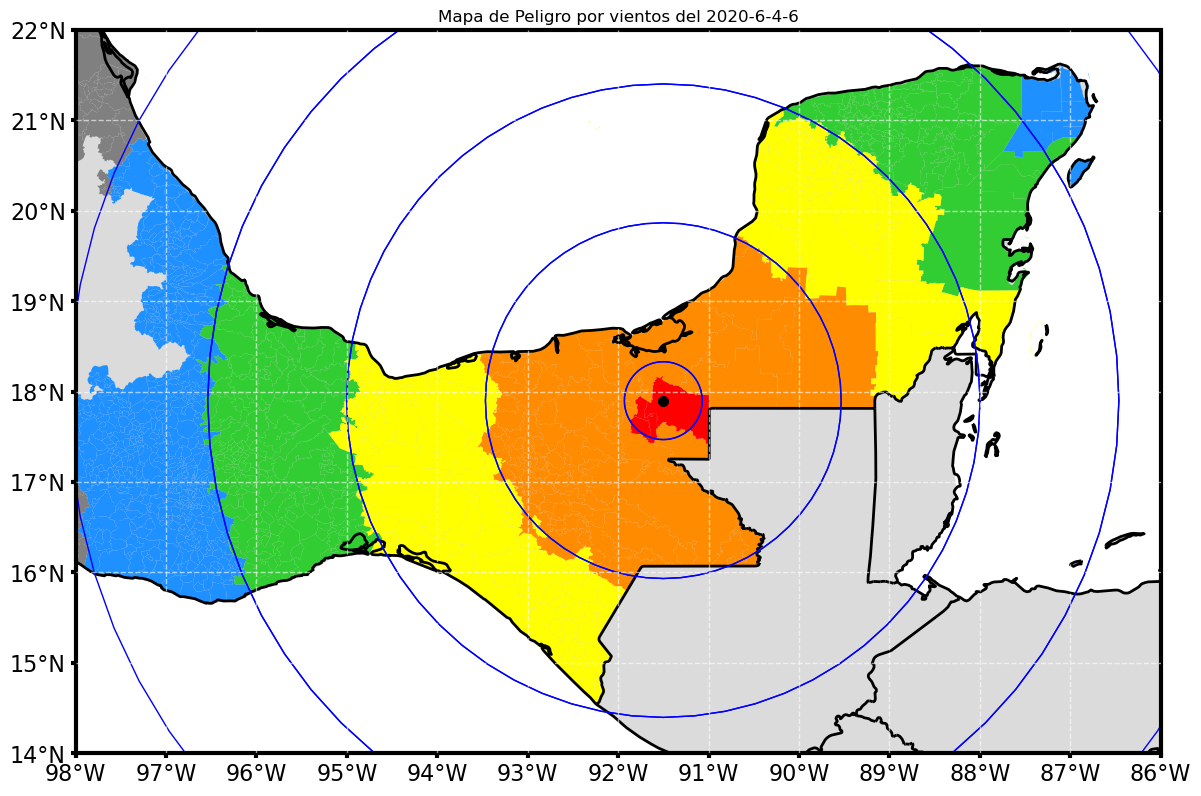

In [36]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
municipios_gdf.plot(column='Peligro', ax=ax, cmap=c_scale)
for anillo in anillos:
    gpd.GeoSeries([anillo]).boundary.plot(ax=ax, color='blue', linewidth=1)
ax.plot(centro_ciclon[1], centro_ciclon[0], marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')
nombre = str(data.iloc[indice].yy)+'-'+str(data.iloc[indice].mm)+'-'+str(data.iloc[indice].dd)+'-'+str(data.iloc[indice].hh)
plt.title('Mapa de Peligro por vientos del '+ nombre)

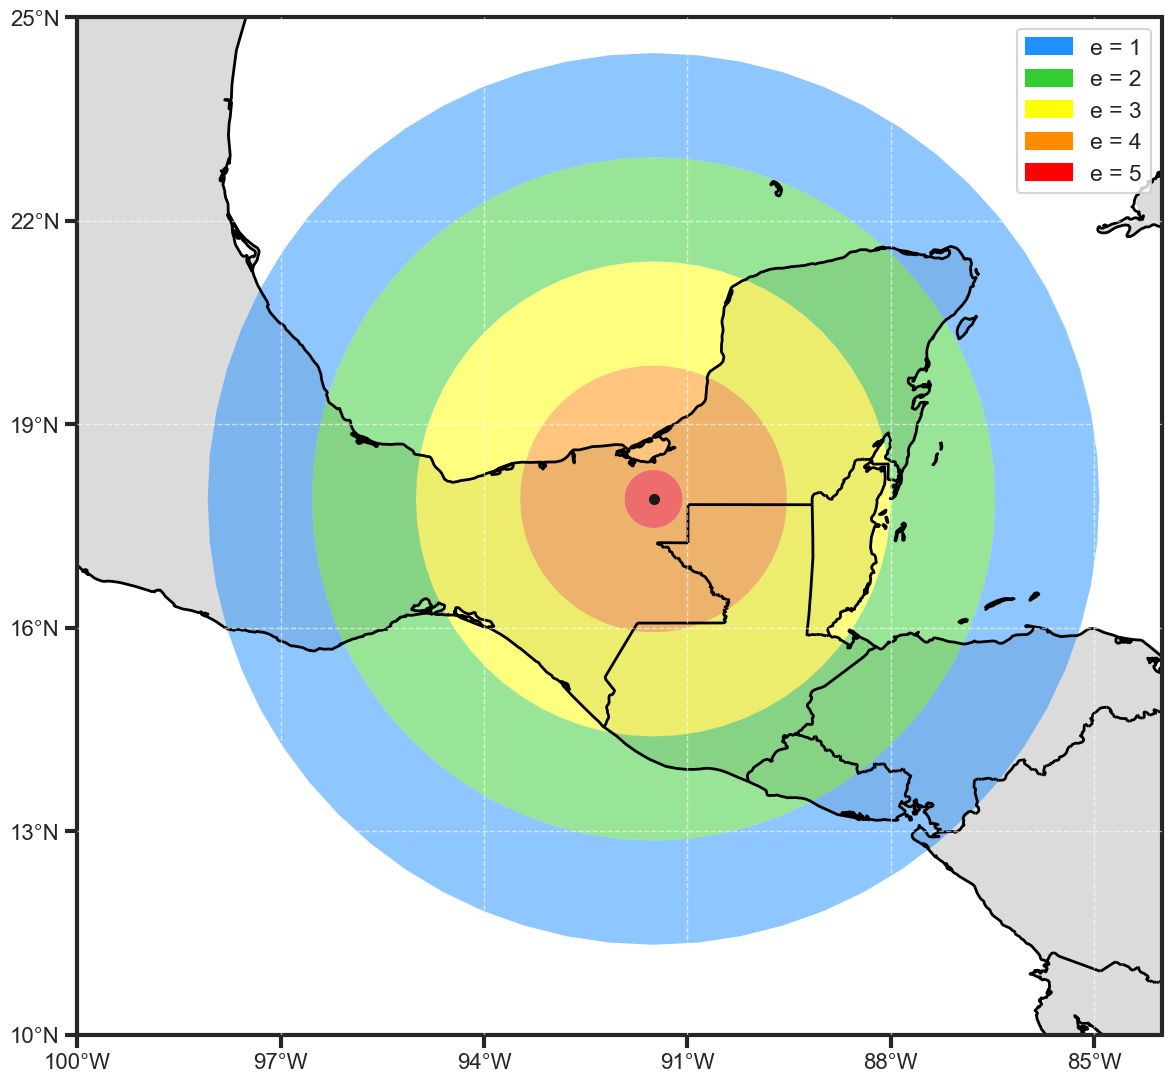

In [315]:
from itertools import cycle

def configurar_mapa(ax, lon_extent=[-100, -84], lat_extent=[10, 25]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=16)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 3), ylocs=range(lat_extent[0], lat_extent[1] + 1, 3))

# Crear un GeoDataFrame con los datos de los anillos
gdf_anillos = gpd.GeoDataFrame(geometry=anillos)

# Crear el subplot con la configuración del mapa
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection": ccrs.PlateCarree()})
configurar_mapa(ax)

# Colores para rellenar los anillos
colores = ['red', 'darkorange', 'yellow', 'limegreen', 'dodgerblue']

# Iterar sobre los anillos y sus colores correspondientes
for anillo, color in zip(gdf_anillos.geometry, colores):
    anillo_patch = gpd.GeoSeries([anillo]).plot(ax=ax, color=color, alpha = 0.5 , edgecolor='none', linewidth=0)
    
ax.plot(centro_ciclon[1], centro_ciclon[0], marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

import matplotlib.patches as mpatches

LegendElement = [
                 mpatches.Patch(color='dodgerblue', label='e = 1'),
                 mpatches.Patch(color='limegreen', label='e = 2'),
                 mpatches.Patch(color='yellow', label='e = 3'),
                 mpatches.Patch(color='darkorange', label='e = 4'),
                 mpatches.Patch(color='red', label='e = 5')
                 ]

ax.legend(handles = LegendElement, loc='upper right')

plt.savefig("fig_9.jpeg", dpi= 300, bbox_inches='tight')


In [310]:
anillos

[<POLYGON ((-91.071 17.9, -91.073 17.858, -91.079 17.816, -91.089 17.775, -91...>,
 <POLYGON ((-89.542 17.707, -89.57 17.516, -89.617 17.329, -89.682 17.147, -8...>,
 <POLYGON ((-88.014 17.557, -88.064 17.217, -88.148 16.883, -88.264 16.559, -...>,
 <POLYGON ((-86.485 17.406, -86.558 16.917, -86.678 16.437, -86.845 15.972, -...>,
 <POLYGON ((-84.957 17.256, -85.052 16.617, -85.208 15.991, -85.426 15.384, -...>]

In [304]:
for i, anillo in enumerate(anillos):
    print(colores[i])

red
orange
yellow
green
blue


## PELIGRO POR PRECIPITACION 

In [316]:
names = ['dd','mm','yy','hh','lat', 'lon', 'MWS', 'CPSL',
         'RNE', 'RNO', 'RSO', 'RSE','Rp','A','D','S','TC']
dfNA = pd.read_table('../MAESTRIAtres/800/NA880.dat', names=names, index_col=False )

In [317]:
CRIS_ROC = dfNA[dfNA.TC.eq('AL032020')].copy()
CRIS_ROC = CRIS_ROC.reset_index(drop = True)

# Define el centro y radio del ciclón
indice = 12
center_lon, center_lat = CRIS_ROC.iloc[indice].lon , CRIS_ROC.iloc[indice].lat  # Ejemplo: coordenadas del centro
radius_km = CRIS_ROC.iloc[indice].Rp  # Radio en kilómetros
nombre = str(CRIS_ROC.iloc[indice].yy)+'-'+str(CRIS_ROC.iloc[indice].mm)+'-'+str(CRIS_ROC.iloc[indice].dd)+'-'+str(CRIS_ROC.iloc[indice].hh)

In [318]:
pcpr = 'lluvia/2020155.15.nc'
ds = nc.Dataset(pcpr)
lat = ds.variables['lat'][599:850]
lon = ds.variables['lon'][699:1000]
time = ds.variables['time'][0]
pcp = ds.variables['precipitation'][0,599:850,699:1000]
lon_grid, lat_grid = np.meshgrid(lon, lat)


In [319]:
nombre = str(CRIS_ROC.iloc[indice].yy)+'-'+str(CRIS_ROC.iloc[indice].mm)+'-'+str(CRIS_ROC.iloc[indice].dd)+'-'+str(CRIS_ROC.iloc[indice].hh)

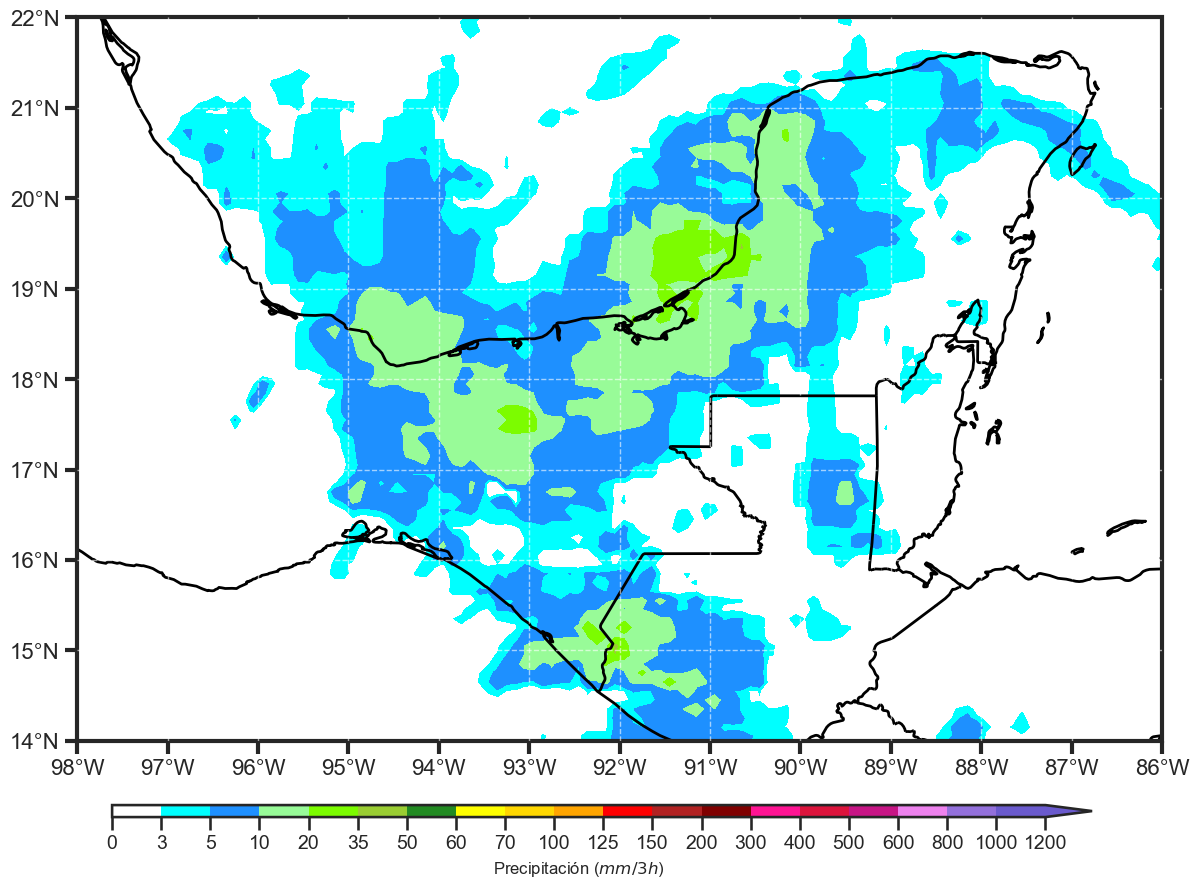

In [339]:
f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
# Los límites de tus categorías
bins = [0, 3, 5, 10, 20, 35, 50, 60, 70, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]
# ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Crear la norma con los límites
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=256)

Q = ax.contourf(lon,lat, pcp, 100,cmap=pcp_rain, norm=norm, transform=ccrs.PlateCarree(),zorder = 1)
sm = plt.cm.ScalarMappable(cmap=pcp_rain, norm=norm)
sm.set_array([])
cbar_ax = f.add_axes([0.15, 0.13, 0.7, 0.01])  # Ajusta las dimensiones [left, bottom, width, height] según necesites
puntos1 = bins  # Ajusta los ticks de la escala de color
cbar = f.colorbar(sm, cax=cbar_ax, ticks=puntos1, orientation='horizontal', extend='max')
cbar.set_label('Precipitación ($mm / 3h$)',fontsize = 12)
cbar.ax.tick_params(labelsize=14)
plt.savefig("fig_10a.jpeg", dpi= 300, bbox_inches='tight')

In [353]:
radius_km/111.1

9.220702070207022

In [373]:
centro = Point(center_lon,center_lat)  # Invertir para que sea (lon, lat)
circle_deg = centro.buffer(radius_km / 111.1)  # Convertir km a grados aprox.

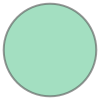

In [374]:
circle_deg

In [375]:
# Cargar GeoDataFrame de municipios
municipios = siat_ct.iloc[:,:11].copy()

# Proyectar municipios al mismo CRS que el círculo si es necesario
municipios = municipios.to_crs(epsg=4326)  # Asegúrate de que ambos usen WGS84 o ajusta según sea necesario

# Calcular intersección
municipios['intersected'] = municipios['geometry'].intersection(circle_deg)

In [378]:
# Convertir cada punto de precipitación a un punto Shapely
points = [Point(lon, lat) for lon, lat in zip(lon_grid.flatten(), lat_grid.flatten())]
precip_points = gpd.GeoDataFrame({'geometry': points, 'precipitation': pcp.flatten()})

# Filtrar puntos con precipitación > 0 y que están dentro del círculo del ciclón
precip_points = precip_points[precip_points['geometry'].within(circle_deg)]

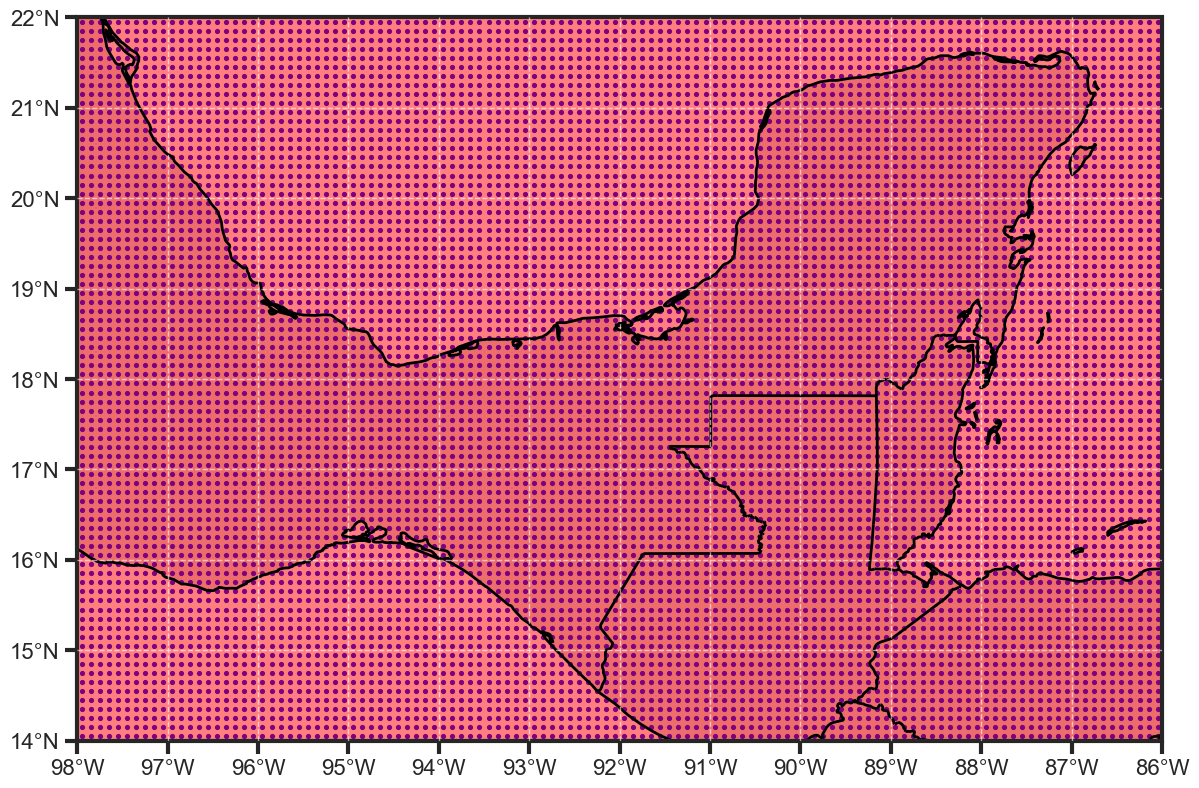

In [383]:

f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)

# Graficar los puntos de precipitación dentro del círculo del ciclón
precip_points.plot(ax=ax, color='blue', markersize=5, label='Precipitación')

# Graficar el círculo del ciclón
circle_gdf.plot(ax=ax, color='red', alpha=0.5, label='Círculo del ciclón')

plt.savefig("fig_10b.jpeg", dpi= 300, bbox_inches='tight')

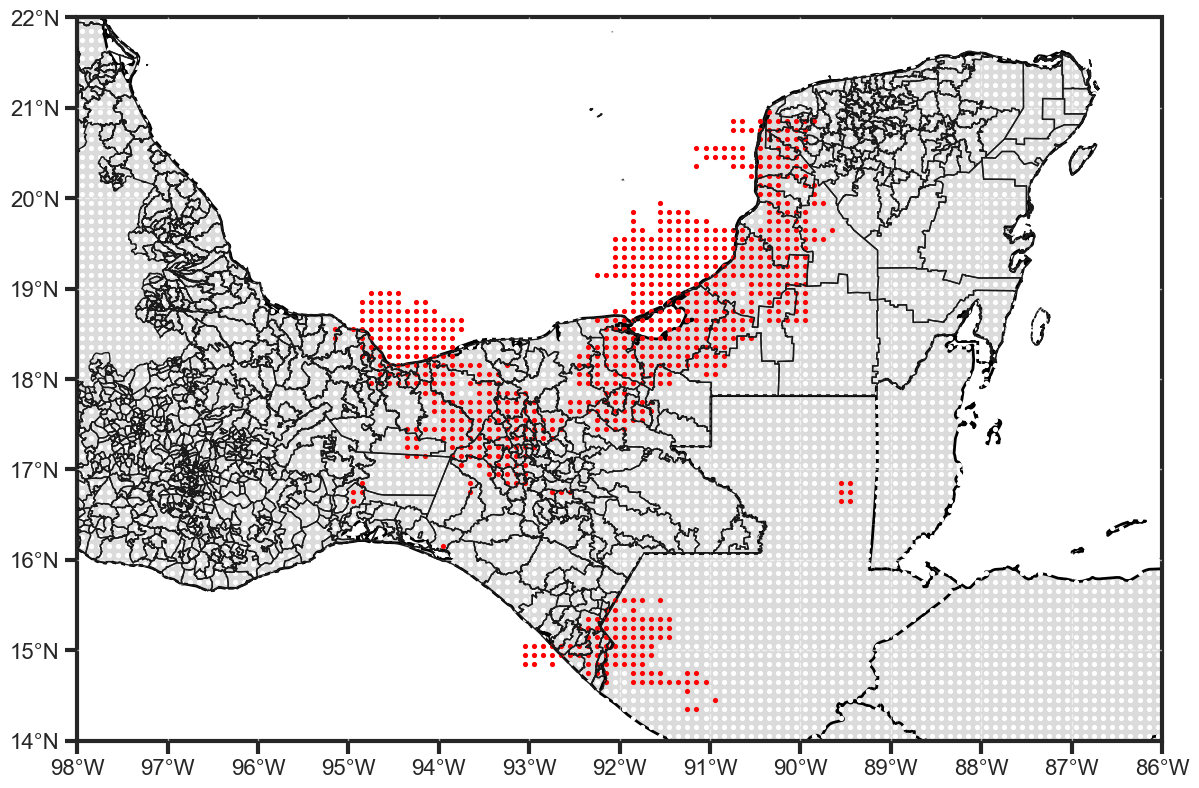

In [394]:

f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)

# Graficar los puntos de precipitación dentro del círculo del ciclón
municipios.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1, zorder=4)

precip_points.plot(ax=ax, color='white', markersize=5, label='Precipitación', zorder =2)

precip_points[precip_points.precipitation.ge(10)].plot(ax=ax, color='red', markersize=5, label='Precipitación', zorder =3)
plt.savefig("fig_10c.jpeg", dpi= 300, bbox_inches='tight')

In [395]:
# Calcular precipitación máxima, acumulada y fracción de puntos con precipitación significativa por municipio
results = []
for index, municipio in municipios.iterrows():
    # Todos los puntos dentro del municipio
    all_points_in_municipio = precip_points[precip_points['geometry'].within(municipio['geometry'])]
    
    # Puntos dentro del municipio con precipitación > 0
    significant_precip_points_in_municipio = all_points_in_municipio[all_points_in_municipio['precipitation'] > 10]
    
    max_precip = significant_precip_points_in_municipio['precipitation'].max() if not significant_precip_points_in_municipio.empty else 0
    total_precip = significant_precip_points_in_municipio['precipitation'].sum()
    
    # Fracción de puntos con precipitación > 0 respecto a todos los puntos posibles dentro del municipio
    if not all_points_in_municipio.empty:
        fraction_significant = len(significant_precip_points_in_municipio) / len(all_points_in_municipio)
    else:
        fraction_significant = 0
    results.append({
        'CVEGEO': municipio['CVEGEO'],
        'municipio': municipio['NOMGEO'],
        'CVE_ENT':municipio['CVE_ENT'],
        'CVE_MUN':municipio['CVE_MUN'],
        'geometry':municipio['geometry'],
        'max_precip': max_precip,
        'total_precip': total_precip,
        'fraction_significant': fraction_significant
    })

results_df = pd.DataFrame(results)

In [396]:
pcp_danger = gpd.GeoDataFrame(results_df,geometry='geometry')
pcp_danger['danger'] = pcp_danger['fraction_significant'].apply(calculate_danger_level)

In [400]:
escala_a_usar = []
for colors in pcp_danger['danger'].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

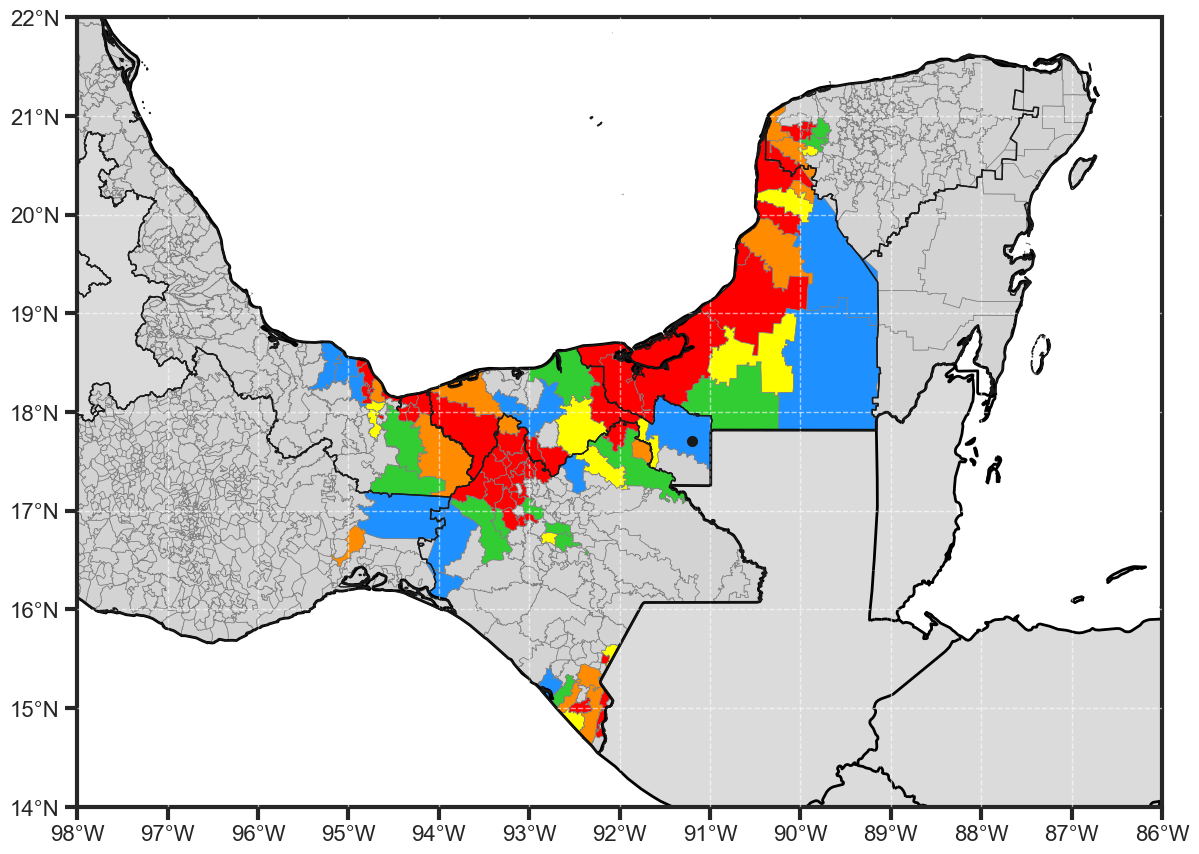

In [406]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
pcp_danger.plot(column='danger', ax=ax, cmap=c_scale, edgecolor='grey', linewidth=0.5,)
estados.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1, zorder=3)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')
# plt.title('Mapa de Peligro por Precipitación acumulada en 3h del ' + nombre)

plt.savefig("fig_10d.jpeg", dpi= 300, bbox_inches='tight')

Text(0.5, 1.0, 'Mapa de Peligro por Precipitación acumulada en 3h del 2020-6-4-12')

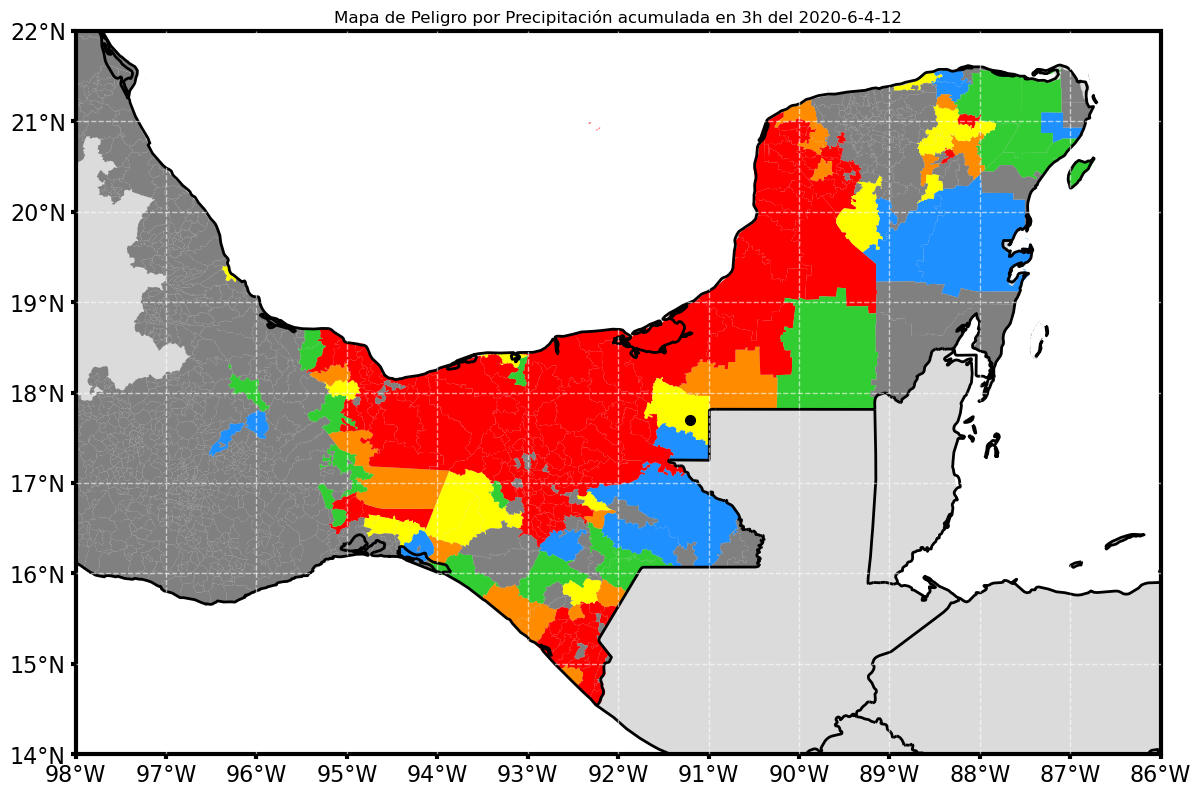

In [48]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
pcp_danger.plot(column='danger', ax=ax, cmap=c_scale)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')
plt.title('Mapa de Peligro por Precipitación acumulada en 3h del ' + nombre)

# PELIGRO POR VIENTOS Y PRECIPITACION EN CONJUNTO (EN PROCESO DE DESARROLLO COMPLEMENTARIO )

In [57]:
wind_danger = municipios_gdf.copy()
peligro_ct = pcp_danger.merge(wind_danger[['CVEGEO','Peligro']].set_index('CVEGEO'), on = 'CVEGEO')

In [58]:
peligro_ct = peligro_ct.rename(columns={
    'Peligro': 'wind_danger',  # Cambia 'Peligro' a 'wind_danger'
    'danger': 'pcp_danger'    # Cambia 'danger' a 'pcp_danger'
})
peligro_ct['ct_danger'] = peligro_ct[['wind_danger', 'pcp_danger']].max(axis=1)

In [59]:
escala_a_usar = []
for colors in peligro_ct['ct_danger'].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

Text(0.5, 1.0, 'Alertas promedio 2020-6-4-12')

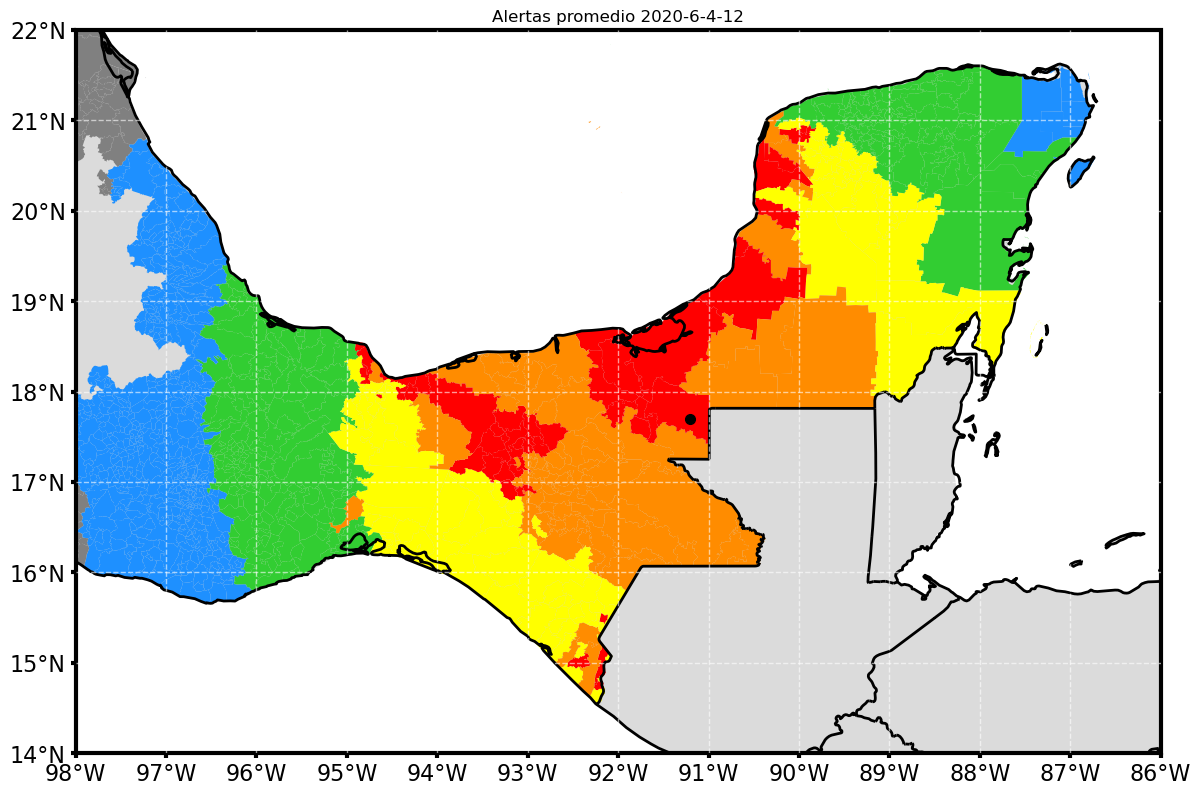

In [60]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

peligro_ct.plot(column='ct_danger', ax=ax, cmap=c_scale)
plt.title('Alertas promedio ' + nombre)


Text(0.5, 1.0, 'Alertas promedio 2020-6-4-12')

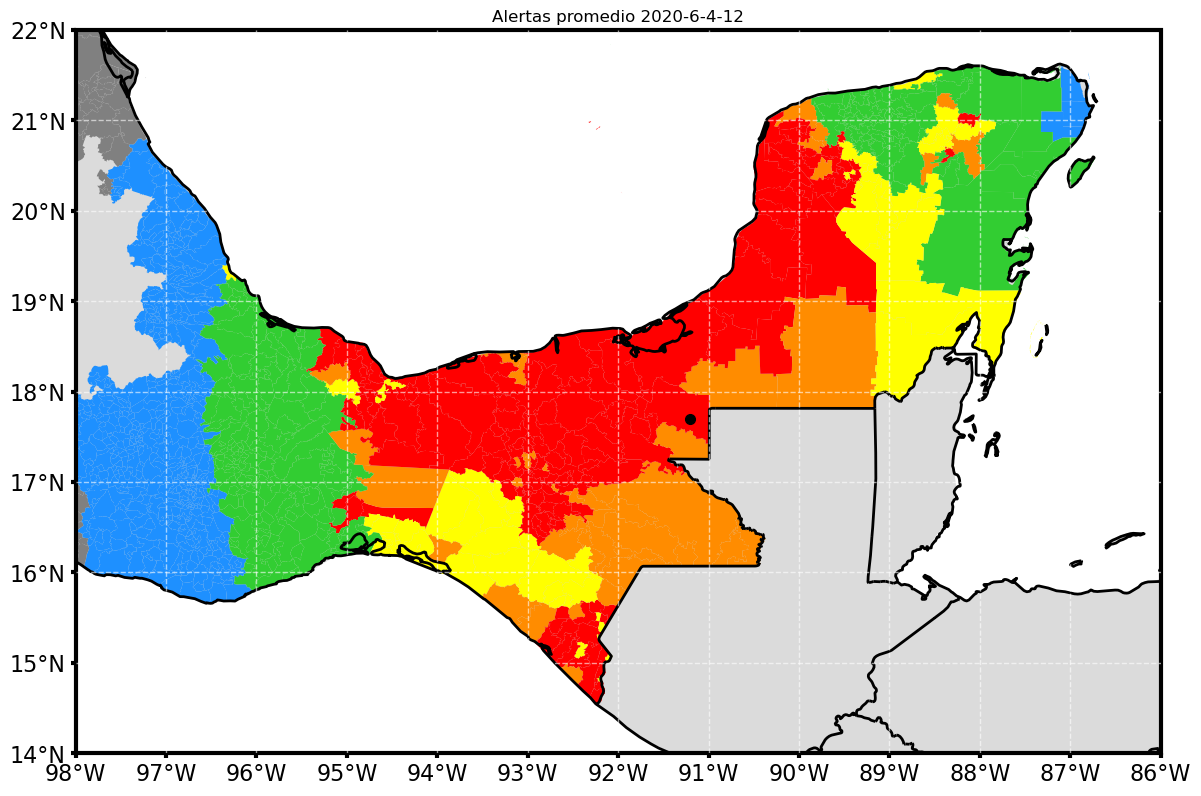

In [52]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

peligro_ct.plot(column='ct_danger', ax=ax, cmap=c_scale)
plt.title('Alertas promedio ' + nombre)


In [430]:
def configurar_mapa(ax, lon_extent=[-98, -86], lat_extent=[ 14, 22]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=14)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 3), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 3), ylocs=range(lat_extent[0], lat_extent[1] + 1, 3))


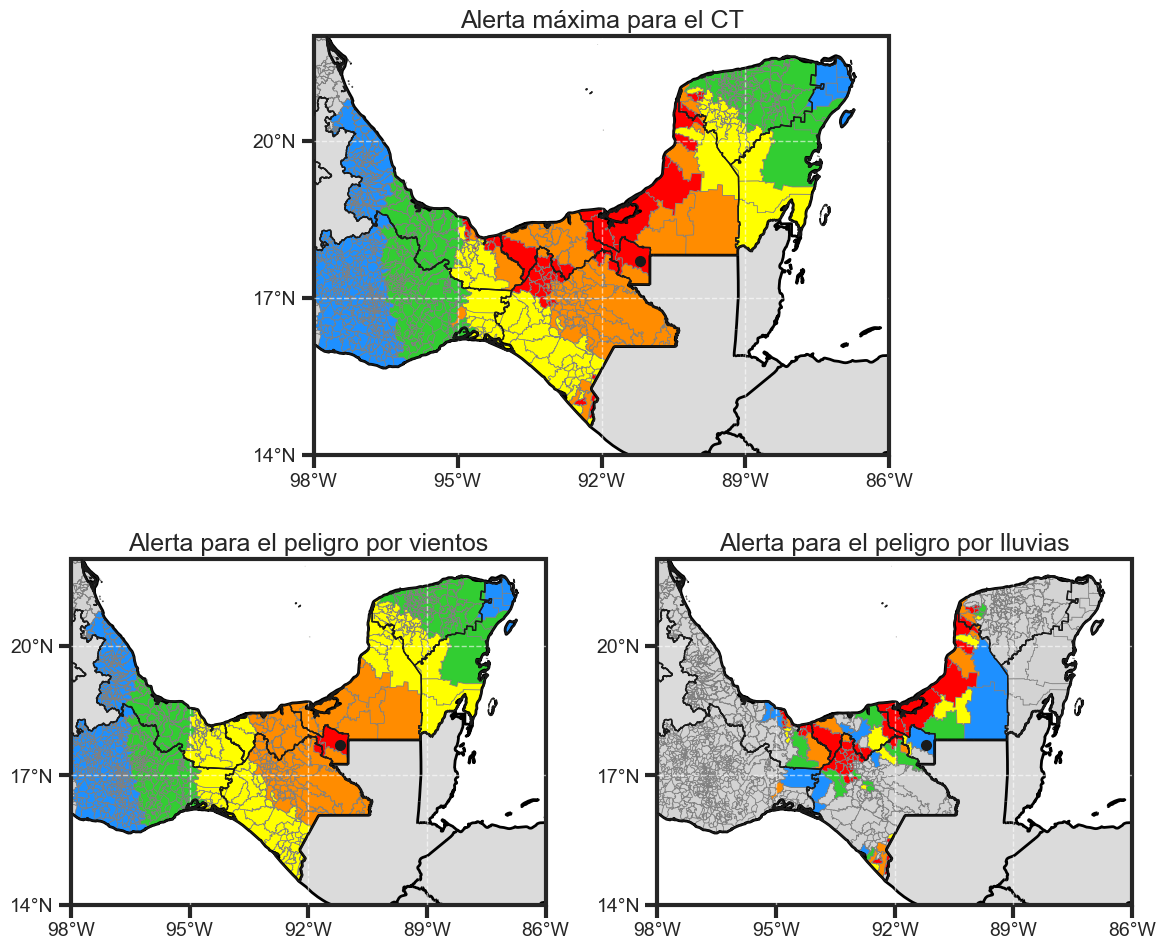

In [441]:
# Configuración del mapa principal
fig = plt.figure(figsize=(12, 10))

# Mapa principal
ax_main = fig.add_subplot(2, 2, (1, 2), projection=ccrs.PlateCarree())
ax_main.set_title('Alerta máxima para el CT')
configurar_mapa(ax_main)
peligro_ct.plot(column='ct_danger', ax=ax_main, cmap=c_scale, edgecolor='grey', linewidth=0.5,)
estados.plot(ax=ax_main, color = 'none', edgecolor='k', linewidth=1, zorder=3)
ax_main.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Subgráfico 1 (arriba a la izquierda)
ax_sub1 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax_sub1.set_title('Alerta para el peligro por vientos')
configurar_mapa(ax_sub1)
municipios_gdf.plot(column='Peligro', ax=ax_sub1, cmap=c_scale, edgecolor='grey', linewidth=0.5,)
estados.plot(ax=ax_sub1, color = 'none', edgecolor='k', linewidth=1, zorder=3)
ax_sub1.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Subgráfico 2 (arriba a la derecha)
ax_sub2 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax_sub2.set_title('Alerta para el peligro por lluvias')
configurar_mapa(ax_sub2)
pcp_danger.plot(column='danger', ax=ax_sub2, cmap=c_scale, edgecolor='grey', linewidth=0.5,)
estados.plot(ax=ax_sub2, color = 'none', edgecolor='k', linewidth=1, zorder=3)
ax_sub2.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

plt.tight_layout()
plt.savefig("fig_11.jpeg", dpi= 300, bbox_inches='tight')